In [34]:
import pickle
import numpy as np
import pandas as pd
import pygeohash as pgh
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import reverse_geocode as rg_cities
from scipy.stats import entropy
import plotly.express as px 
import seaborn as sns
import math
import country_converter as coco
from urllib.request import urlopen
import json

from geopy.geocoders import Nominatim

from datetime import datetime
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=4)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = 'iframe'
!rm -rf iframe_figures

# Detecting Seasonal Patterns in User Movement

There is more to human movement than periodic patterns and social-based movement. While the paper accurately predicts human movement throughout the week, we propose a more all-encompassing analysis that paints a broader picture, exploring monthly and seasonal movement. To do so, we will use the original check-in and friendship datasets from Gowalla and Brightkite and separate them into subsets representing a narrower time of the year. We want to see what mobility patterns are exhibited in different countries and throughout different times of the year: users can go on vacation, travel abroad, and change homes. This would allow us to understand the travelling patterns of users around the world (i.e. who is more likely to travel and where) as well as the distribution of check-ins and their density. We want to produce visualizations showcasing these patterns on a world map. 

Our starting point is the first replication of the Friendship and Mobility paper. We re-use the data-loading and data cleaning part, as well as the technique to determine home locations.

## Loading the data

In [3]:
# The datasets have no headers, so we have to name them for clarity
checkin_header = ['user', 'checkin_time', 'latitude', 'longitude', 'location_id']
edges_header = ['user1', 'user2']

# Load the data by specifying the correct compression algorithm, separator and column names
checkin_brightkite_orig = pd.read_csv('data/loc-brightkite_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_brightkite_orig = pd.read_csv('data/loc-brightkite_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)
checkin_gowalla_orig = pd.read_csv('data/loc-gowalla_totalCheckins.txt.gz', compression = 'gzip', sep = '\t', names = checkin_header)
edges_gowalla_orig = pd.read_csv('data/loc-gowalla_edges.txt.gz', compression = 'gzip', sep = '\t', names = edges_header)

## Cleaning the data

Some of the latitude and longitude values are not in the valid range of [-90, 90] and [-180, 180] respectively. Moreover, the location having (lat, long) = (0,0) is not a valid one. In both datasets, we remove rows in which either of the location attributes are not valid. We also remove the rows of the Brightkite dataset that have NaN values. 

In [4]:
def clean(checkins):
    """ Rids the check-in data of invalid coordinates """
    to_drop = []
    # Select indexes to drop depending on conditions mentionned above 
    to_drop.append(checkins[(checkins['latitude'] < -90.0) | 
                                   (checkins['latitude'] > 90.0)].index)
    to_drop.append(checkins[(checkins['longitude'] < -180.0) | 
                                   (checkins['longitude'] > 180.0)].index)
    to_drop.append(checkins[(checkins['latitude'] == 0) & 
                                   (checkins['longitude'] == 0)].index)
    
    for item in to_drop:
        checkins.drop(item, inplace = True)
    checkins.dropna(inplace = True)
    
    return checkins

In [5]:
# Pass copy of DataFrama in order not to have to reload the original one in case of a mistake
checkin_brightkite = clean(checkin_brightkite_orig.copy())
checkin_gowalla    = clean(checkin_gowalla_orig.copy())

## Adding temporal information to the check-in data

To be able to separate check-ins temporally, we add to each check-in: the day of the week, month, season and year. We also add the hour of the week (a number between 0 and 167). 

In [6]:
def to_datetime(string_date):
    """ Returns the string found in the row to the correctly formatted datetime object """
    return datetime.strptime(string_date, '%Y-%m-%dT%H:%M:%SZ')

def get_season(row):
    """ 
        Returns the season from a certain row
        Adapted from https://stackoverflow.com/a/28688724 
    """
    # Define the datetime intervals according to every season
    Y = 2000 # Leap year to allow input X-02-29, which allows for leap days
    seasons = [('winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
               ('spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
               ('summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
               ('autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
               ('winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]
    
    date_time = row['checkin_time'].replace(year=Y, hour=0, minute=0, second=0)
    return next(season for season, (start, end) in seasons if start <= date_time <= end)

seasons = ['winter', 'spring', 'summer', 'autumn']
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',\
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

In [7]:
# Convert datetime strings to datetime objects
checkin_brightkite['checkin_time'] = checkin_brightkite['checkin_time'].parallel_apply(to_datetime)
checkin_gowalla['checkin_time'] = checkin_gowalla['checkin_time'].parallel_apply(to_datetime)

# Find the month associated with every check-in
checkin_brightkite['month'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].month, axis=1)
checkin_gowalla['month'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].month, axis=1)

# # Find the year associated with every check-in
checkin_brightkite['year'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].year, axis=1)
checkin_gowalla['year'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].year, axis=1)

# Find the season associated with every check-in
checkin_brightkite['season'] = checkin_brightkite.parallel_apply(get_season, axis=1)
checkin_gowalla['season'] = checkin_gowalla.parallel_apply(get_season, axis=1)

# Find the day of week associated with every check-in
checkin_brightkite['day_of_week'] = checkin_brightkite.parallel_apply(lambda row: row['checkin_time'].weekday(), axis=1)
checkin_gowalla['day_of_week'] = checkin_gowalla.parallel_apply(lambda row: row['checkin_time'].weekday(), axis=1)

# Find the hour of week assoiated with every check-in (used for entropy) 
checkin_brightkite['hour_of_week'] = checkin_brightkite.parallel_apply(lambda row: row['day_of_week']*24 + row['checkin_time'].hour, axis=1)
checkin_gowalla['hour_of_week'] = checkin_gowalla.parallel_apply(lambda row: row['day_of_week']*24 + row['checkin_time'].hour, axis=1)

checkin_brightkite.head()

,user,checkin_time,latitude,longitude,location_id,month,year,season,day_of_week,hour_of_week
0,0,2010-10-17 01:48:53,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,10,2010,autumn,6,145
1,0,2010-10-16 06:02:04,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,10,2010,autumn,5,126
2,0,2010-10-16 03:48:54,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,10,2010,autumn,5,123
3,0,2010-10-14 18:25:51,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,10,2010,autumn,3,90
4,0,2010-10-14 00:21:47,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,10,2010,autumn,3,72


## Analyzing the data's temporal distribution

As we plan on analyzing the temporal distribution of check-ins and on finding monthly or seasonal patterns, the data needs to be consistent across the time period we want to study. To visualize this, we plot the distribution of the number of checkins as a function of the month and the year. 

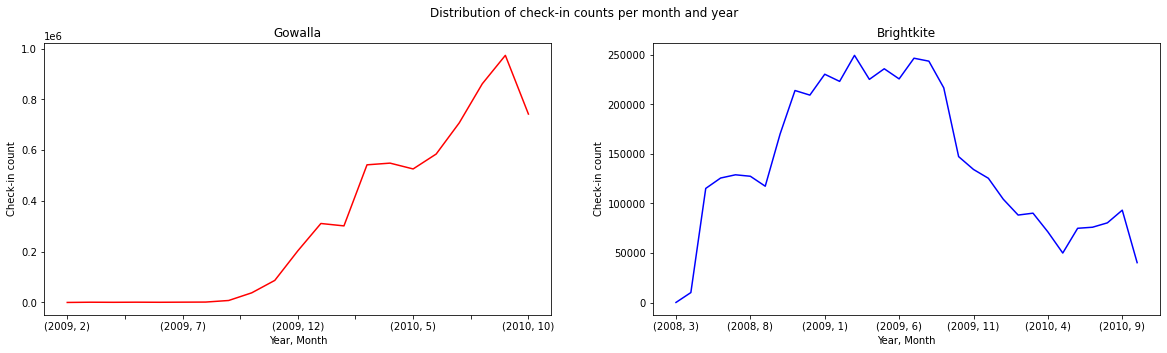

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))

# Plot the check-in counts per month and year for both data sets
checkin_gowalla.groupby(['year', 'month']).count()['user'].plot(ax = axs[0], title = 'Gowalla', color = 'red')
checkin_brightkite.groupby(['year', 'month']).count()['user'].plot(ax = axs[1], title = 'Brightkite', color = 'blue')

for ax in axs:
    ax.set_xlabel('Year, Month')
    ax.set_ylabel('Check-in count')
plt.suptitle('Distribution of check-in counts per month and year')
plt.show()

We notice that for the Gowalla dataset, there is no consistency across monthly check-in growth: the monthly number of check-ins keeps growing and never stabilizes. This will pose a problem while analyzing check-in patterns for different months. Indeed, this might result in unbalanced and skewed results. Therefore, we decided to drop this dataset for the rest of the study. Later in this notebook, we applied one of our analyses on the Gowalla dataset to show this lack of coherence.

As for the Brightkite dataset, the check-ins are more consistent on a monthly basis, except at the two ends of the available timeline. In order to avoid some months being weighted more than others, we keep check-ins spanning two calendar years, from May 1st 2008 until April 30th 2010. The plots below shows that the distribution is more balanced over that filtered timeline: we avoid months with a check-in count close to zero. More specifically, we avoid some months having less or more check-ins than others.

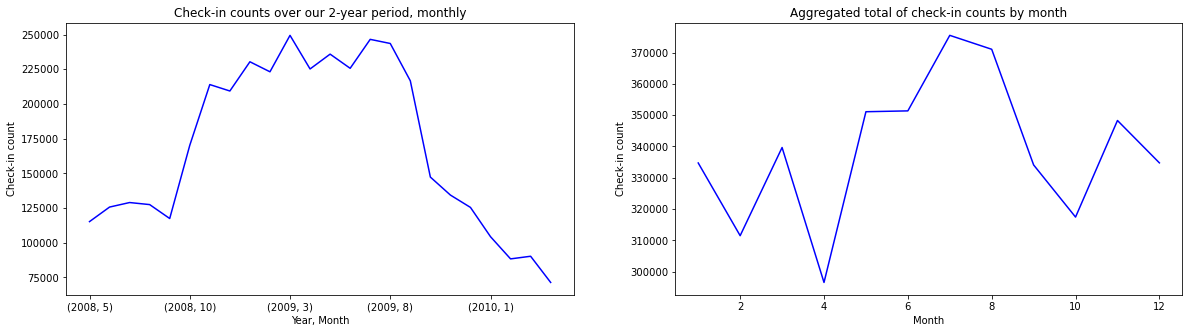

In [9]:
# Keep a subset of the check-ins for the period mentioned above
bright_kite_test = checkin_brightkite[(checkin_brightkite['checkin_time'] >= datetime(2008, 5, 1, 0, 0, 0)) & (checkin_brightkite['checkin_time'] < datetime(2010, 5, 1, 0, 0, 0))]

fig, axs = plt.subplots(1, 2, figsize = (20, 5))

# Plot the distributions
bright_kite_test.groupby(['year','month']).count()['user'].plot(ax = axs[0], xlabel = 'Year, Month', ylabel = 'Check-in count', color = 'blue')
bright_kite_test.groupby(['month']).count()['user'].plot(ax = axs[1], xlabel = 'Month', ylabel = 'Check-in count', color = 'blue')

# Plot attributes
axs[0].title.set_text("Check-in counts over our 2-year period, monthly")
axs[1].title.set_text("Aggregated total of check-in counts by month")
plt.show()

In [10]:
# Keep the check-ins over the two year period
checkin_brightkite = bright_kite_test

## Adding country information to check-ins

For each check-in, we append the country code corresponding to the country the check-in was made in. This is done using a reverse geohashing library [`reverse_geocoder`](https://github.com/thampiman/reverse-geocoder) that maps coordinates (latitutde, longitude) to information about a specific place (e.g. city, country, country code).

In [11]:
def extract_coordinates(row):
    return (row['latitude'], row['longitude'])

def coordinates_to_country(df):
    """
        Maps the coordinates of a dataframe to the country
        code using reverse geocoding
    """
    coordinates_tuples = list(df.parallel_apply(extract_coordinates, axis = 1))
    geocodes = rg.search(coordinates_tuples)
    return [gc['cc'] for gc in geocodes]

In [12]:
# Append country codes to each check-in for both datasets
checkin_brightkite['cc'] = coordinates_to_country(checkin_brightkite)

checkin_brightkite.head()

Loading formatted geocoded file...


,user,checkin_time,latitude,longitude,location_id,month,year,season,day_of_week,hour_of_week,cc
374,0,2010-04-30 22:18:15,39.709787,-104.940615,5c9d5704151bc90e7da29704e51dddb0,4,2010,spring,4,118,US
375,0,2010-04-30 21:42:05,39.685557,-104.940307,b16c562014fdd0d027e852b33bf6d238,4,2010,spring,4,117,US
376,0,2010-04-30 05:02:15,39.756503,-104.901302,1ba076fa060611de969d003048c10834,4,2010,spring,4,101,US
377,0,2010-04-30 00:38:15,39.740376,-104.949861,506872e616c1168088ad6fe9315270e4,4,2010,spring,4,96,US
378,0,2010-04-29 03:56:23,39.676832,-105.107894,99c69de12794ff4b0f503786cd3f48118410b39f,4,2010,spring,3,75,US


## Determining the location of user homes

Here, the geohash is used to determine the home location for every user. Since this is similar to what was done in the replication, we will not go into detail about the implementation and justification.

In [13]:
def geohash_encode(row, precision = 4):
    """
        Computes and returns the geohash with 
        precision 4 for a given row 
    """
    return pgh.encode(*extract_coordinates(row), precision=precision)

def find_home(checkins, user_id):
    """
        Given a user id, finds the most common world cell and 
        computes average location to estimate home location
    """
    # Retrieve all the user's check-ins
    group = checkins[checkins['user']  == user_id]
    # Get the most common geohash for the user
    geohash = group.groupby('geohash').size().idxmax()
    
    # Keep all checkins that happened in the most common geohash and compute average position
    return group[group['geohash'] == geohash][['latitude', 'longitude']].mean()

In [14]:
# Compute the geohash for each check-in entry: that will determine the cell in which each check-in belongs
checkin_brightkite['geohash'] = checkin_brightkite.parallel_apply(geohash_encode, axis = 1)

In [15]:
# All the users that made at least 1 check-in
brightkite_users = set(checkin_brightkite.user)

# Create empty DataFrame with user ids and apply function to all users
brightkite_homes = pd.DataFrame(index = brightkite_users).index.to_series().parallel_apply(lambda user_id: find_home(checkin_brightkite, user_id)) 

# Add the country codes to the homes
brightkite_homes['cc'] = coordinates_to_country(brightkite_homes)

In [16]:
# Store homes in dictionary for faster access
brightkite_homes = brightkite_homes.to_dict(orient = 'index')

## Identify travelers

We now indentify users who travel. We define a traveler as a user who has made at least one check-in outside of his home country (determined by the country of its home location). From this definition, we mark each check-in depending on whether it was made while abroad or not. 

In [17]:
def travel_check(row, homes):
    """ 
        A check-in corresponds to a travel if it was made in a country 
        different than the user's home country
    """
    return row['cc'] != homes[row['user']]['cc']

In [18]:
# Determine whether each check-in corresponds to a check-in made while abroad
checkin_brightkite['is_abroad'] = checkin_brightkite.parallel_apply(lambda row: travel_check(row, brightkite_homes), axis = 1)
checkin_gowalla['is_abroad'] = checkin_gowalla.parallel_apply(lambda row: travel_check(row, gowalla_homes), axis = 1) # to show that gowalla can't be used

## When are users more likely to travel ?

During certain periods, it is natural that people break their weakly movenent pattern: whether it is for a vacation or a work trip, users will check-in far from their home. We are interested in understanding these traveling patterns. This entails finding the time of the year users are more likely to check-in at a location abroad (in a country different from their home country) or travel far from home. 

Naturally, users that made check-ins outside of their home country will tend to travel further. For each season, we plot the distribution of home distances for both datasets and separate check-ins made while abroad from the rest. 

In [19]:
# Credits of the function implementation: https://stackoverflow.com/a/15737218
from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
        Calculates the great circle distance (in km) between two points 
        on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [20]:
def get_distance_from_home(row, homes):
    """ 
    calulate_home_distance_bk: calulates the distance between two lat/long coordinaes, which
                               in this case are the homes of two friends using the coordinates
                               in the bk_user_homes dataframe
    arg row: a row from the dataframe containingn friend data
    """  
    home_lat = homes[row['user']]['latitude']
    home_long = homes[row['user']]['longitude']

    return haversine(home_lat, home_long, row['latitude'], row['longitude'])

In [27]:
# Compute the distance between each check-in and the home of the user that made it 
checkin_brightkite['distance_from_home'] = checkin_brightkite.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

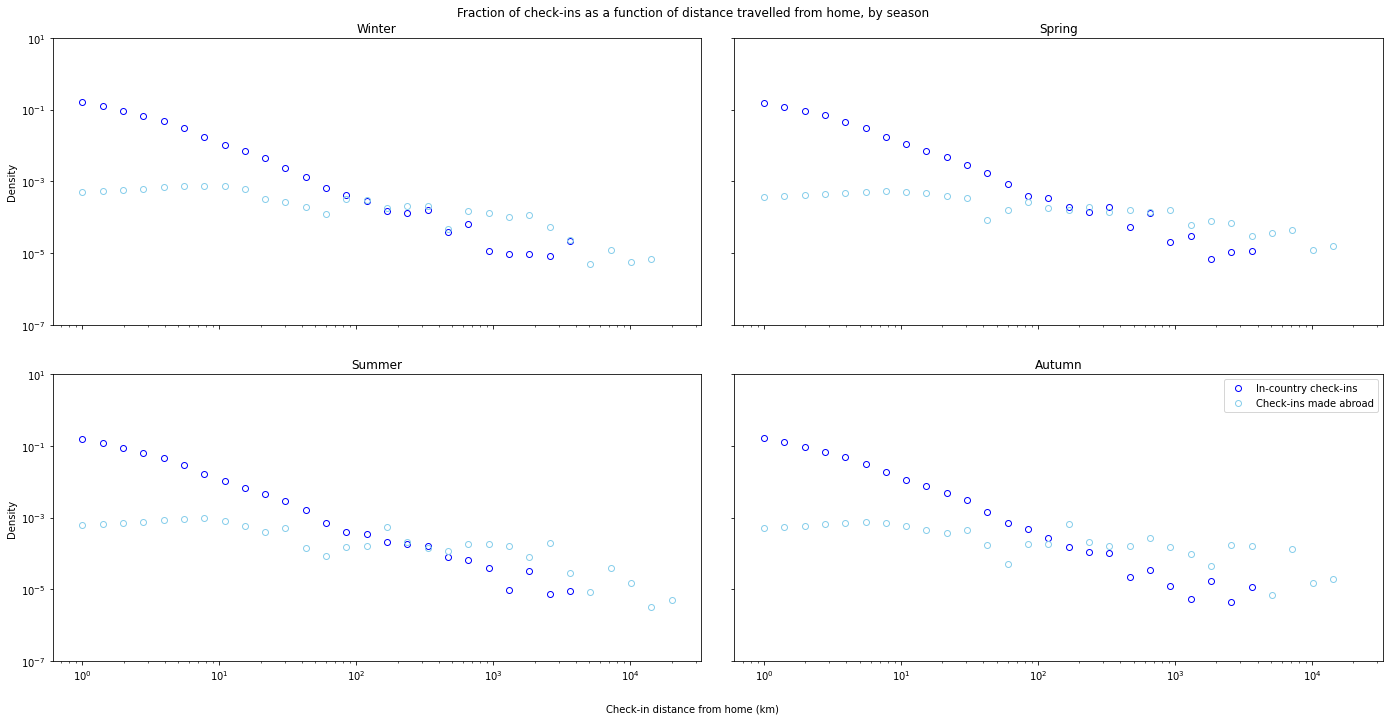

In [28]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex = True, sharey = True)
axs = axs.ravel()

# Store the max distance, for KDE evaluation logspace
max_dist = math.log10(checkin_brightkite.distance_from_home.max())

for i, season in enumerate(seasons):
    # For each season, plot the distribution of check-in distances from home for check-ins made abroad and in-country 
    checkin_brightkite[(~checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'blue', ax = axs[i])
    checkin_brightkite[(checkin_brightkite['is_abroad']) & (checkin_brightkite['season'] == season)].distance_from_home.plot.kde(bw_method = 0.001, ind = np.logspace(0, max_dist, 30), loglog=True, 
                                                                 ls = '', marker = 'o', fillstyle = 'none', color = 'skyblue', ax = axs[i])
    
    axs[i].title.set_text(season.capitalize())

# Plot attributes
fig.tight_layout(pad = 3)
fig.text(0.5, 0, 'Check-in distance from home (km)', ha='center')
plt.ylim(10e-8, 10e0)
plt.legend(['In-country check-ins', 'Check-ins made abroad'])
plt.suptitle('Fraction of check-ins as a function of distance travelled from home, by season')
plt.show()

The trend for each season is very similar. We do not see any particular increase in the probability of traveling further depending on the season. 
- Notice that, for in-country check-ins (solid color), the probability of checking-in far from home is high at a close distance, and decreases the further the check-in is. 
- For check-ins made abroad (pastel color), the probability of checking-in close to home is low, but stays rather constant for a long ditance (with a slight decrease towards 1000km).

We plot the frequency of check-ins made abroad for each month, to try and find periods during which people travel more. This will tell us if there are popular months among travelers (i.e summer months). 

In [35]:
fig = px.bar(data_frame= checkin_brightkite[checkin_brightkite['is_abroad']].groupby('month')['user'].count(), 
             labels={'month': 'Month', 'value': 'Check-in count'}, color_discrete_sequence = px.colors.sequential.Plasma)

fig.update_layout(xaxis = dict(tickmode = 'array',
                               tickvals = list(months.keys()), 
                               ticktext = list(months.values())))
fig.update_layout(title_text='Distribution of check-ins made abroad, per month', title_x = 0.5, showlegend=False) 
fig.show()

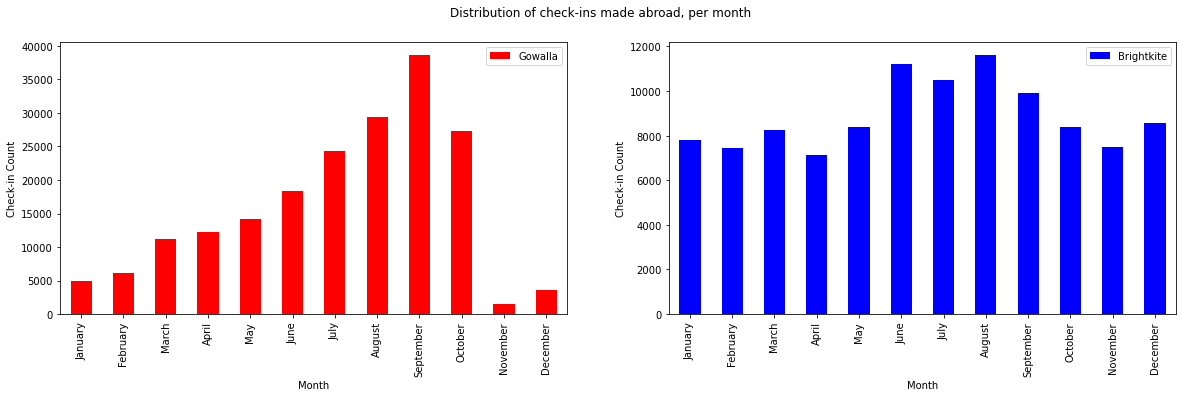

In [30]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
axs = axs.ravel()

# Plot the frequency of check-ins made abroad for each month
checkin_gowalla[checkin_gowalla['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'red', ax = axs[0])
checkin_brightkite[checkin_brightkite['is_abroad']].groupby('month')['user'].count().plot.bar(color = 'blue', ax = axs[1])

for ax in axs:
    ax.set_xlabel('Month')
    ax.set_ylabel('Check-in Count')
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels(months.values())
    ax.tick_params('x', rotation = 90)

axs[0].legend(['Gowalla'])
axs[1].legend(['Brightkite'])
plt.suptitle('Distribution of check-ins made abroad, per month')
plt.show()

We see a spike in the frequency of check-ins abroad in June, July, September and August, i.e. summer months. This means that users tend to travel more during summer, even though some smill travel during the rest of the year. 

> Notice that the Gowalla plot shows a monthly grows of check-in counts, which is not stable enough to carry out our analysis. As stated previously, we will drop that dataset from now on. 

### Analyzing monthly and seasonal entropy

We will now compute the entropy of check-in locations for each month. In order to do so, we need a way to represent neighboring locations as one single entity: we will reuse geohashes, but this time with a larger precision. Even though this does not indicate whether users travel abroad, it still shows the variability of their movement throughout the year. To compute the entropy, we use `scipy.stat`'s entropy method that takes as input value counts. 

In [31]:
# Compute geohash of all check-ins with larger precision
checkin_brightkite['geohash_precision5'] = checkin_brightkite.parallel_apply(lambda row: geohash_encode(row, precision=5), axis = 1)

In [32]:
brightkite_monthly_entropies = []

for i in range(12):
    # Compute the entropy of the check-in locations using geohashes over each month
    monthly = checkin_brightkite[checkin_brightkite['month'] == i + 1]
    avg_entropy = monthly.groupby('user').apply(lambda group: entropy(pd.Series(group.geohash_precision5).value_counts(), base=2) ).mean()
    brightkite_monthly_entropies.append(avg_entropy)

# Plot the monthly entropies
fig = px.bar(x=months.values(), y=brightkite_monthly_entropies, 
             labels={'x': 'Month', 'y': 'Location Entropy'})
fig.update_layout(title_text='Entropy of check-in locations over each month', title_x = 0.5) 
fig.show()

We observe that the entropy is higher during the summer (and the summer months). This shows that the variability of check-ins is higher during that time period and hints at higher non-periodic user movement in summer. That change certainly due to the fact that people tend to go out and take vacations when it's warmer.

### Analyzing weekly entropy on a monthly/seasonal basis

After analyzing the entropy of locations over a whole period of time, we will now analyze the same metric on a weekly basis (for each hour of the week), and plot it for every period of time (i.e. seasons or months).

In [ ]:
brightkite_weekly_entropies = []

for m in range(0, 12): # Repeat the computation for each month
    entropies_brightkite = []
    monthly = checkin_brightkite[checkin_brightkite['month'] == m + 1]
    for i in range(168):
        hour = monthly[monthly['hour_of_week'] == i]
        avg_entropy = hour.groupby('user').apply(lambda group: entropy(pd.Series(group.geohash_precision5).value_counts(), base=2) ).mean()
        # For each hour of the week, compute the entropy of the week's hour for the given month
        entropies_brightkite.append(avg_entropy)
    brightkite_weekly_entropies.append(entropies_brightkite)    
    print("Done for month {}".format(m+1))

In [ ]:
fig = go.Figure()

# Plot the entropies for each hour of the week, for each month
for i in range(0,12):
    fig.add_trace(go.Scatter(y=brightkite_weekly_entropies[i], name=months[i+1]))

fig.update_layout(title_text='Weekly entropy aggregated over each month<br><i>(click on legend to toggle trace)</i>', title_x = 0.5, 
                 xaxis_title = 'Hour of Week', yaxis_title = 'Location Entropy') 

# Add vertical lines corresponding to days
weekdays = list()
for i in range(24, 167, 24):
    weekdays.append(dict(
        type= 'line',
        yref= 'paper', y0= 0, y1= 1,
        xref= 'x', x0= i, x1= i
    ))
fig.update_layout(shapes=weekdays)

# Add vertical lines labels
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(range(12, 169, 24)),
        ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
)

fig.show()

We notice that the location entopy during the week-ends is always higher, as it was pointed out by the authors of the original paper. This trend is further accentuated during the summer (e.g. July and August). This means that the people's movement patterns vary more and are less predictable. For other seasons, notably the spring and autumn, people seem to be more set in their routines, hence the slightly lower entropy. 

## How does the home location change temporally

During summer, holidays or even weekends, it is common for people to live in another place for a few weeks, e.g in a summer house or mountain cottage. We would now like to study what is the proportion of users that change homes throughout the year, and check if these home changes correspond to a special period of the year. We will carry out this analyzis mainly by computing user homes for each period of the year (months and seasons).

To start, we only consider check-ins that were not made abroad, i.e. check-ins that were made in the main home location of the user that made them. We do this to avoid the following scenario. A user from the US is on vacation in Thailand in July, and does some check-ins there: this means we will assign the user a home in Thailand, which is not accurate. 

In [110]:
# Keep check-ins that were not made abroad
brightkite_incountry = checkin_brightkite[~checkin_brightkite['is_abroad']] 

# Print statistics on the numeber of check-ins per user
brightkite_checkins_per_user = {user: len(checkins) for user, checkins in brightkite_incountry.groupby('user')}
pd.Series(brightkite_checkins_per_user).describe()

count    50686.000000
mean        86.500118
std        255.068318
min          1.000000
25%          3.000000
50%         10.000000
75%         48.000000
max       2100.000000
dtype: float64

Notice that 50% of users have made 10 check-ins or less, which is not enough to determine a monthly home location. Moreover, 75% of the users have made 48 check-ins or less. To have pertinent results, we decide to keep the check-ins of users that made 10 check-ins or more: these users are called active users.

In [111]:
# Keep users who made at least 10 check-ins (active users)
brightkite_active_users = [user for user, n_checkins in brightkite_checkins_per_user.items() if n_checkins >= 10 ]

# Keep the check-ins of active users only
brightkite_incountry = brightkite_incountry[brightkite_incountry['user'].isin(brightkite_active_users)]

Once the check-ins have been filtered, we can proceed to find the home location of users for each period. We store the check-ins and results in dictionary with the months/seasons as keys. 

To compute the home locations, we use the same technique as above, but:
- We consider the set of users that made a check-in during the period of interest, 
- We base the calculation on the check-ins made during the period of interest. 

Note that some users might not have made check-ins during every period of interest: we therefore set the home location of such users for that period as their main (yearly) home location.  

In [116]:
# Dictionary: month/season -> DataFrame of check-ins made during that month/season
brightkite_monthly = { month: checkins for month, checkins in brightkite_incountry.groupby('month') }
brightkite_season = { season: checkins for season, checkins in brightkite_incountry.groupby('season') }

# Dictionary: month/season -> DataFrame of home locations during that month/season
brightkite_homes_monthly = {}
brightkite_homes_season = {}

for month, checkins in brightkite_monthly.items():
    # Users that made a check-in during the period
    users = checkins.user.unique()
    
    # Find the homes of the users, based on the check-ins made during that month 
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    
    # Add country location
    result['cc'] = coordinates_to_country(result)
    # Compute the distance from users' main home location
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    # Determine users that didn't made a check-in during that period: retrieve their home location
    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    # Distance is zero since home location didn't change
    missing['dist_from_yearly_home'] = 0
    
    # Append missing users to result
    result = result.append(missing, ignore_index=True)
    brightkite_homes_monthly[month] = result    
    
# Repeat the process for each season
for season, checkins in brightkite_season.items():
    users = checkins.user.unique()    
    result = pd.DataFrame(index = users).index.to_series().parallel_apply(lambda user_id: find_home(checkins, user_id))
    result = result.reset_index().rename(columns={'index':'user'})
    result['cc'] = coordinates_to_country(result)
    result['dist_from_yearly_home'] = result.parallel_apply(lambda row: get_distance_from_home(row, brightkite_homes), axis=1)

    missing = pd.DataFrame.from_dict(brightkite_homes, orient = 'index', columns = ['latitude', 'longitude', 'cc']).reset_index().rename({'index': 'user'}, axis = 1)
    missing = missing[~missing['user'].isin(checkins.user.unique())]
    missing['dist_from_yearly_home'] = 0
    
    result = result.append(missing, ignore_index=True)
    brightkite_homes_season[season] = result

Done for month 1
Done for month 2
Done for month 3
Done for month 4
Done for month 5
Done for month 6
Done for month 7
Done for month 8
Done for month 9
Done for month 10
Done for month 11
Done for month 12
Done for season autumn
Done for season spring
Done for season summer
Done for season winter


To visualize when does the home location of users change, we decided to:
1. Plot the average distance from the users' main (yearly) home
2. Compute and plot the percentage of users that change homes for each period. 

We say that a user changed homes if the distance from his yearly home is greater than 100km apart. We chose 100km as a threshold because, according to the paper, people live in cities that are separated by that distance or more.

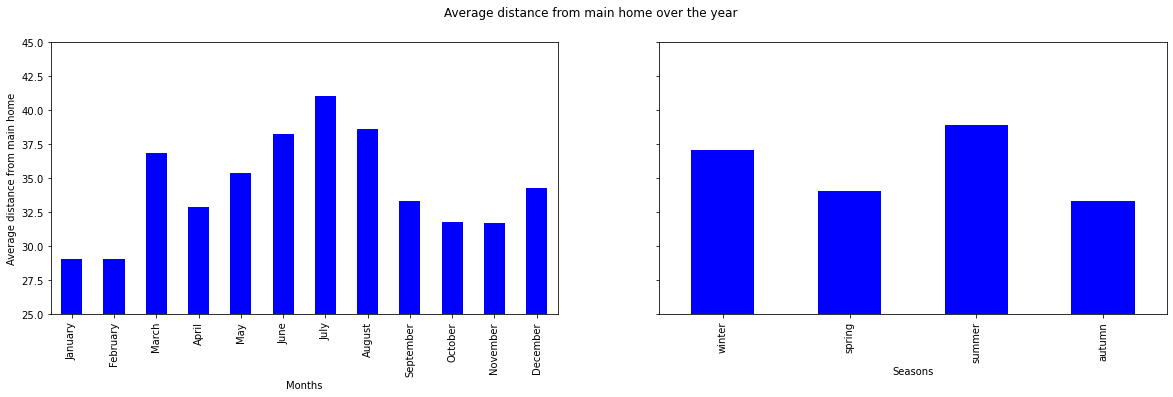

In [117]:
# Collect the distances from yearly home for each month and season
brightkite_monthly_distances = {month: homes.dist_from_yearly_home.mean() for month, homes in brightkite_homes_monthly.items()}
brightkite_season_distances = {season: brightkite_homes_season[season].dist_from_yearly_home.mean() for season in seasons}

fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()

# Plot distances from the main home for each period
pd.Series(brightkite_monthly_distances).plot.bar(ax = axs[0], color = 'blue')
pd.Series(brightkite_season_distances).plot.bar(ax = axs[1], color = 'blue')

# Plot attributes
axs[0].set_xlabel('Months')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[1].set_xlabel('Seasons')
axs[0].set_ylabel('Average distance from main home')
plt.ylim(25, 45)

plt.suptitle('Average distance from main home over the year')
plt.show()

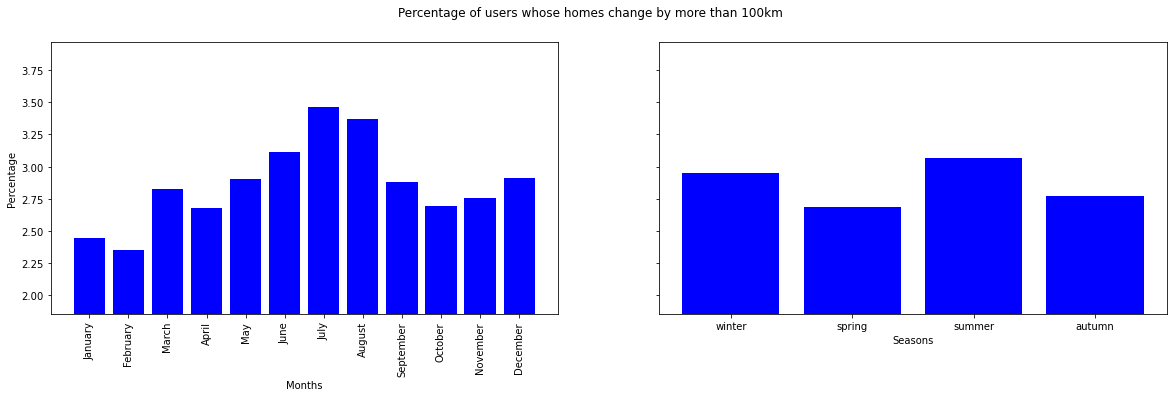

In [118]:
threshold = 100 # People live in cities more than 100km apart
brightkite_monthly_percentages = []
brightkite_season_percentages = []

# Compute the percentage of people who have a new home further than the treshold
for month in range(1, 13):
    distances = brightkite_homes_monthly[month].dist_from_yearly_home
    brightkite_monthly_percentages.append(100*len(distances[distances > threshold])/len(distances))

for season in seasons:
    distances = brightkite_homes_season[season].dist_from_yearly_home
    brightkite_season_percentages.append(100*len(distances[distances > threshold])/len(distances))
        
fig, axs = plt.subplots(1, 2, figsize = (20, 5), sharey = True)
axs = axs.ravel()
    
# Plot percentages for each time period
axs[0].bar(x = range(0, 12), height=brightkite_monthly_percentages, color = 'blue')
axs[1].bar(x = seasons, height=brightkite_season_percentages, color = 'blue')

# Plot attributes
axs[0].set_xlabel('Months')
axs[0].set_ylabel('Percentage')
axs[0].set_xticks(range(0, 12))
axs[0].set_xticklabels(months.values())
axs[0].tick_params(axis='x', rotation= 90)
axs[1].set_xlabel('Seasons')
plt.ylim(min(brightkite_monthly_percentages) - 0.5, max(brightkite_monthly_percentages) + 0.5)

plt.suptitle('Percentage of users whose homes change by more than {}km'.format(threshold))
plt.show()

In [3]:
checkin_brightkite = pickle.load(open('pickles/checkin_brightkite', 'rb'))
brightkite_homes = pickle.load(open('pickles/brightkite_homes', 'rb'))

## Analyzing international travel destinations

In this part, we look into check-ins that were made while the user was abroad, i.e. those that correspond to travels. 

### Who travels where ?

We first study the distribution of travel check-ins as a function of the destination and the user's nationality, depending on the season. A user's nationality is simply the country of her primary home. For visualization purposes, we only carry out the analysis on the 25 most frequent destinations and nationalities. 

In [38]:
# Determine users nationality 
checkin_brightkite['user_nationality'] = checkin_brightkite['user'].parallel_apply(lambda user: brightkite_homes[user]['cc'])

In [39]:
# Isolate check-ins made while travelling
checkin_brightkite_abroad = checkin_brightkite[checkin_brightkite['is_abroad']]

# Find the top countries  
brightkite_top_countries = checkin_brightkite_abroad.groupby('cc').count()['user'].sort_values(ascending=False)
brightkite_top_countries = list(brightkite_top_countries[:25].index)

# Find the top nationalities
brightkite_top_nationalities = checkin_brightkite_abroad.groupby('user_nationality').count()['user'].sort_values(ascending=False)
brightkite_top_nationalities = list(brightkite_top_nationalities[:25].index)

# Keep check-ins made in top countries by top nationalities
checkin_brightkite_abroad = checkin_brightkite_abroad[checkin_brightkite_abroad['cc'].isin(brightkite_top_countries)
                                                     & checkin_brightkite_abroad['user_nationality'].isin(brightkite_top_nationalities)]

Because the Brightkite dataset is dominated by users living in the US, there is naturally more travelers from there: this observation puts more focus on their check-ins to the detriment of the check-ins in other countries and from other nationalities. To account for this, we clamp the colormap's max value: this better displays travel involving other nationalities and destination countries. Restricting the max value also allows us to accurately compare trends across seasons.

In [40]:
# Plot the heatmap: count of check-ins as a function of nationality and destinations
fig = px.density_heatmap(checkin_brightkite_abroad.sort_values('month'), x = 'cc', y = 'user_nationality', animation_frame='season',
                         labels = {'user_nationality': 'Nationality of Traveler', 'cc': 'Destination', 'season': 'Season'}, range_color = [0, 800],
                         height = 800, width = 800, category_orders={'user_nationality': list(checkin_brightkite_abroad.user_nationality.sort_values()), 
                                                                       'cc': list(checkin_brightkite_abroad.cc.sort_values())})
fig.update_layout(title_text='Number of Check-ins Made Abroad by Travelers', title_x = 0.5) 

fig['layout']['updatemenus'][0]['pad'] = dict(r=10, t=50)
fig['layout']['sliders'][0]['pad'] = dict(r=10, t=50)

fig.show()

At first glance, there is more travel happening during the summer, as expected. We notice these slight changes:
- Austria gets an increase in visits from Swiss, German, Dutch and British travelers during the winter. This is probably due to the popularity of the skiing industry in the country. 
- A lot of people from China go to Taiwan during the winter, and to Singapore during the summer. 
- Germany gets a high number of visits from neighbouring countries during the fall: this coincides with the Oktoberfest celebrations. 

We noticed that South-African users tend to travel almost exclusively to Finland in winter, and to Thailand in the remaining seasons. A closer data inspection shows that all these check-ins point back to two users (one for each of the destinations). Furthermore, almost all of these check-ins are at the exact same location. We conclude that such unusual patterns are probably generated by a bot.   

### Finding popular tourist locations

We're interested into finding the locations most people travel to. We add the city information to each check-in in the format `city, country`, to avoid considering cities like Cambrige (UK) and Cambridge (US) as one. We then computed the number of check-ins per city with their check-in position, and kept cities with more than a hundred check-ins. 

> We are aware that some countries have cities with the same name (e.g. Lebanon, Illinois and Lebanon, Virginia), but we found that this approach was good enough for the application. 

Note that we used a different reverse geocoding library for this step (`reverse_geocode` instead of `reverse_geocoder`) as it gives more accurate information about the exact city (rather than larger administrative regions).  

In [41]:
# Extract lat, long tuples from each check-in
checkin_brightkite_coords = list(checkin_brightkite.parallel_apply(extract_coordinates, axis = 1))
# Determine the city corresponding to each check-in coordinates
checkin_brightkite['city'] = ['{}, {}'.format(gc['city'], gc['country']) for gc in rg_cities.search(checkin_brightkite_coords)]

In [42]:
# Keep check-ins that were made while traveling, i.e. abroad
checkin_brightkite_abroad = checkin_brightkite[checkin_brightkite['is_abroad']].copy()

In [43]:
# Group check-ins per city and count the number of check-ins in each group. 
# Each group will have as coordinates, the element-wise average of each check-in's coordinate
tourist_cities = checkin_brightkite_abroad.groupby('city')[['latitude', 'longitude', 'user']].aggregate({'latitude': 'mean', 'longitude' : 'mean', 'user': 'count'})\
                                          .reset_index().rename(columns = {'user' : 'checkins'})

# Display some stats about the number of check-ins per city
tourist_cities.checkins.describe()

count    9665.000000
mean       11.038800
std        52.422892
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max      1725.000000
Name: checkins, dtype: float64

The distribution of the number of check-ins per cities is skewed. Notice that 75% of cities have 5 check-ins or less. Given that there are above 9000 cities, we cannot possibly take into account every city. We wil therefore keep cities with more than 100 check-ins 

In [44]:
# Keep cities that have more than 100 check-ins
tourist_cities = tourist_cities[tourist_cities['checkins'] > 100]
print('There are {} tourist cities with more than 100 check-ins'.format(len(tourist_cities)))

There are 171 tourist cities with more than 100 check-ins


In [45]:
# Plot the tourist cities' locations on a map, with the size as a 3rd dimension
fig = px.scatter_mapbox(tourist_cities,lat="latitude", lon="longitude", size="checkins", hover_name='city', 
                        height = 800, width = 1200, center={'lat': 35.941851, 'lon': -5.496089}, zoom = 1, 
                       color_discrete_sequence = px.colors.sequential.Plasma)
fig.update_layout(mapbox_style="carto-positron", title_text="Popular tourist cities over the world", title_x = 0.5)
fig.show()

We notice that the most popular cities are mostly metropoles or megalopoles in developed countries. They're mostly *big name* tourist cities that people first think of when picking a destination.

### When people travel, where do they go ?

Now that we've explored the different destinations of users, it is interesting to know where they check-in the most, compared to the local population of their destination city. We will explore the cities of San Francisco and Paris and compare the density of check-ins made by travelers with that of locals. We chose these cities as they contain a high amount of check-ins.

In [46]:
# Take check-ins that correspond to the San Fransico area (the geohash that spans this area)
checkin_brightkite_sf = checkin_brightkite[checkin_brightkite['geohash'].str.startswith('9q8')].sort_values('is_abroad')

In [47]:
# Plot the check-ins in San-Francisco distinguishing local check-ins from tourist ones (with the color)
fig = px.scatter_mapbox(checkin_brightkite_sf,lat="latitude", lon="longitude", color = 'is_abroad', center = {'lat': 37.725207, 'lon': -122.395964},
                        height = 800, width = 1200, labels = {'is_abroad': 'Tourist'})
fig.update_layout(mapbox_style="carto-positron", title_text="Check-ins in the San-Francisco area", title_x = 0.5) 
fig.show()

In [48]:
# Repeat for the Paris area 
checkin_brightkite_paris = checkin_brightkite[checkin_brightkite['geohash'].str.startswith('u09')].sort_values('is_abroad')

In [49]:
fig = px.scatter_mapbox(checkin_brightkite_paris,lat="latitude", lon="longitude", color = 'is_abroad', center = {'lat': 48.845306, 'lon': 2.346271},
                        zoom = 9, height = 800, width = 1200, labels = {'is_abroad': 'Tourist'})
fig.update_layout(mapbox_style="carto-positron", title_text="Check-ins in the Paris area", title_x = 0.5) 
fig.show()

While the local population spreads into Paris' suburbs, the tourists tend to be more concentrated around the city-center (and the airport in that case), where most tourist attractions are located. 

## Analyzing in-country travel destinations

We're now focusing on analyzing the travel trends of users of a certain country, within that country. It would give insight on how locals travel inside their own country during different time of the years. For this part, we will focus on hand-picked countries: the United States, Germany and France. More precisely, we will look into administrative divisions (e.g. states, regions) of each country and study travel trends between them. 

In [50]:
def to_german_bundesland(state):
    """
        Converts the names of German states to German (to be able to 
        use the geojson later on)
    """
    if state == 'Baden-Wuerttemberg':
        return 'Baden-Württemberg'
    if state == 'Bavaria':
        return 'Bayern'
    if state == 'Hesse':
        return 'Hessen'
    if state == 'Lower Saxony':
        return 'Niedersachsen'
    if state == 'North Rhine-Westphalia':
        return 'Nordrhein-Westfalen'
    if state == 'Saxony':
        return 'Sachsen'
    if state == 'Saxony-Anhalt':
        return 'Sachsen-Anhalt'
    if state == 'Thuringia':
        return 'Thüringen'
    return state

In [51]:
def to_french_region(region):
    """
        Converts the names of French regions to French (to be able to 
        use the geojson later on)
    """
    if region == 'Lower Normandy' or region == 'Haute-Normandie':
        return 'Normandie'
    if region == 'Poitou-Charentes' or region == 'Limousin' or region == 'Aquitaine':
        return 'Nouvelle-Aquitaine'
    if region == 'Midi-Pyrenees' or region == 'Languedoc-Roussillon':
        return 'Occitanie'
    if region == 'Auvergne' or region == 'Rhone-Alpes':
        return 'Auvergne-Rhône-Alpes'
    if region == 'Lorraine' or region == 'Alsace' or region == 'Champagne-Ardenne':
        return 'Grand Est'
    if region == 'Nord-Pas-de-Calais' or region == 'Picardie':
        return 'Hauts-de-France'
    if region == 'Bourgogne' or region == 'Franche-Comte':
        return 'Bourgogne-Franche-Comté'
    if region == 'Ile-de-France':
        return 'Île-de-France'
    if region == 'Centre':
        return 'Centre-Val de Loire'
    if region == 'Corsica':
        return 'Corse'
    if region == 'Brittany':
        return 'Bretagne'
    if region == "Provence-Alpes-Cote d'Azur":
        return "Provence-Alpes-Côte d'Azur"
    return region

In [52]:
def extract_state(gc):
    """
        Extracts the state from the geocoder's result. Calls translation
        functions is the country is France or Germany
    """
    if gc['cc'] == 'DE':
        return to_german_bundesland(gc['admin1'])
    if gc['cc'] == 'FR':
        return to_french_region(gc['admin1'])
    return gc['admin1']

In [53]:
# Add the state info to each check-in
checkin_brightkite['state'] = [extract_state(gc) for gc in rg.search(checkin_brightkite_coords)]

# Add the state info to each home location

# Retrieve home coordinates of all users
brightkite_homes_coords = [(home['latitude'], home['longitude']) for home in brightkite_homes.values()]
# Compute the state of all home coordinates
brightkite_homes_states = [extract_state(gc) for gc in rg.search(brightkite_homes_coords)]

# Update user homes with state info 
for i, user in enumerate(brightkite_homes.keys()):
    brightkite_homes[user]['state'] = brightkite_homes_states[i]
    
# Add the home state info for each check-in
checkin_brightkite['home_state'] = checkin_brightkite['user'].parallel_apply(lambda user: brightkite_homes[user]['state'])

In [54]:
checkin_brightkite.head(5)

,user,checkin_time,latitude,longitude,location_id,cc,geohash,month,season,day_of_week,hour_of_week,is_abroad,distance_from_home,geohash_precision5,user_nationality,city,state,home_state
0,0,2010-10-17T01:48:53Z,39.747652,-104.992510,88c46bf20db295831bd2d1718ad7e6f5,US,9xj6,10,autumn,6,145,False,4.006078,9xj64,US,"Denver, United States",Colorado,Colorado
1,0,2010-10-16T06:02:04Z,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2,US,9xj6,10,autumn,5,126,False,13.701001,9xj6c,US,"Broomfield, United States",Colorado,Colorado
2,0,2010-10-16T03:48:54Z,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79,US,9xj6,10,autumn,5,123,False,13.577496,9xj6c,US,"Broomfield, United States",Colorado,Colorado
3,0,2010-10-14T18:25:51Z,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683,US,9xj6,10,autumn,3,90,False,3.730570,9xj64,US,"Denver, United States",Colorado,Colorado
4,0,2010-10-14T00:21:47Z,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc,US,9xj6,10,autumn,3,72,False,3.455918,9xj64,US,"Denver, United States",Colorado,Colorado


Note that we use *state* to refer to a greater administrative division of a country: *région* in France and *Bundesländ* in Germany.

### Case study: United States

The United States is divided into 50 states (and Washington, D.C.). We will observe how people move state to state during different times of the year. A user's home state is simply the state in which that user's main home is located. 

In [55]:
# Isolate check-ins made in the US by US nationals
checkin_brightkite_local_us = checkin_brightkite[(checkin_brightkite['cc'] == 'US') & (checkin_brightkite['user_nationality'] == 'US')]

# Keep check-ins that were made by out-of-state users
checkin_brightkite_local_us = checkin_brightkite_local_us[checkin_brightkite_local_us['state'] != checkin_brightkite_local_us['home_state']]

In [56]:
# Plot the heatmap: count of check-ins as a function of home states and destination states
# Color range is hardcoded to have the same scale for each season
fig = px.density_heatmap(checkin_brightkite_local_us.sort_values('month'), x = 'state', y = 'home_state', animation_frame='season',
                         labels = {'home_state': 'Home State', 'state': 'Destination State', 'season': 'Season'}, range_color = [0, 2200],
                         height = 1200, width = 1200, category_orders={'state': list(checkin_brightkite_local_us.state.sort_values()), 
                                                                       'home_state': list(checkin_brightkite_local_us.home_state.sort_values())})
fig.update_layout(title_text="Check-ins made in the US by Americans from out-of-state, as a function of home states and destination states", title_x = 0.5) 

# Pad slider to avoid overlap with labels
fig['layout']['updatemenus'][0]['pad']=dict(r= 10, t= 150)
fig['layout']['sliders'][0]['pad']=dict(r= 10, t= 150,)

fig.show()

Let's visualize the number of in-country visits to each state, as a function of the season. We scaled down the maximum check-in count to avoid check-in count bias (e.g. one state dominating).

In [57]:
# Json file representing each state's geography with polygons
with urlopen('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json') as response:
    us_states = json.load(response)

# Group check-ins by state and season to get the number of check-ins in each state
seasonal_state_us = checkin_brightkite_local_us.groupby(['state', 'season']).count()['user'].reset_index()

# Plot that on a map 
fig = px.choropleth(seasonal_state_us, geojson=us_states, featureidkey='properties.name',locations='state', 
                    color = 'user', scope = 'usa', animation_frame='season', height = 800, width = 1200,
                    labels = {'state': 'State', 'season': 'Season', 'user': 'Check-ins'},
                    category_orders={'season': ['winter', 'spring', 'summer', 'autumn']}, range_color = [0, seasonal_state_us.user.max()*0.8])
fig.update_layout(mapbox_style="carto-positron", title_text='Check-ins made in the US by Americans from out-of-state, per state', title_x = 0.5) 
fig.show()

We make the following observations about the American trends of in-country travel:
- California is a very popular destination for most regions of the country
- In winter, Texas receives a lot of visitors, especially from Colorado and California: this is probably due to the warmer climate in the state.
- In winter, some people travel to Florida from up North, to escape the cold northern weather.
- In the spring, there is an overall increase in travel. This trend intensifies during the summer, and dies down in autumn.

More generally, we observe travel between neighboring states: this is expected as people can commute across state borders, and because some cities have subsurbs crossing state boundaries. 

### Case study: Germany

We repeat the analysis on Germany's 16 Bundesländer.

In [58]:
# Isolate local germany check-ins made out-of-state
checkin_brightkite_local_de = checkin_brightkite[(checkin_brightkite['cc'] == 'DE') & (checkin_brightkite['user_nationality'] == 'DE')]
checkin_brightkite_local_de = checkin_brightkite_local_de[checkin_brightkite_local_de['state'] != checkin_brightkite_local_de['home_state']]

In [59]:
fig = px.density_heatmap(checkin_brightkite_local_de.sort_values('month'), x = 'state', y = 'home_state', animation_frame='season',
                         labels = {'home_state': 'Home State', 'state': 'Destination State', 'season': 'Season'}, range_color = [0, 200],
                         height = 1200, width = 1200, category_orders={'state': list(checkin_brightkite_local_de.state.sort_values()), 
                                                                       'home_state': list(checkin_brightkite_local_de.home_state.sort_values())})
fig.update_layout(title_text="Check-ins made in Germany by Germans from out-of-state, as a function of home states and destination states", title_x = 0.5) 

fig['layout']['updatemenus'][0]['pad']=dict(r= 10, t= 150)
fig['layout']['sliders'][0]['pad']=dict(r= 10, t= 150,)

fig.show()

In [60]:
# Json file representing each state's geography with polygons
with urlopen('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/master/2_bundeslaender/4_niedrig.geo.json') as response:
    de_states = json.load(response)

# Group check-ins by state and season to get the number of check-ins in each state
seasonal_state_de = checkin_brightkite_local_de.groupby(['state', 'season']).count()['user'].reset_index()

# Plot that on a map 
fig = px.choropleth(seasonal_state_de, geojson=de_states, featureidkey='properties.name',locations='state', 
                    color = 'user', scope='europe', animation_frame='season', height = 800, width = 1200,
                    labels = {'state': 'State', 'season': 'Season', 'user': 'Check-ins'},
                    category_orders={'season': ['winter', 'spring', 'summer', 'autumn']}, range_color = [0, seasonal_state_de.user.max()*0.8])

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='Check-ins made in Germany by Germans from out-of-state, per state', title_x = 0.5) 
fig.show()

In Germany, we notice traveling trends mostly between neigboring states. States containing large cities are popular destinations: Munich in Bayern, Frankfurt in Hessen, Stuttgart in Baden, the city and state of Berlin. Notice that Bayern gets a spike of visitors during autumn (Oktoberfest! 🍺🍻)

### Case study: France

Last but not least, we repeat the analysis on French check-ins.

In [61]:
# Isolate local germany check-ins made out-of-state
checkin_brightkite_local_fr = checkin_brightkite[(checkin_brightkite['cc'] == 'FR') & (checkin_brightkite['user_nationality'] == 'FR')]
checkin_brightkite_local_fr = checkin_brightkite_local_fr[checkin_brightkite_local_fr['state'] != checkin_brightkite_local_fr['home_state']]

In [62]:
fig = px.density_heatmap(checkin_brightkite_local_fr.sort_values('month'), x = 'state', y = 'home_state', animation_frame='season',
                         labels = {'home_state': 'Home State', 'state': 'Destination State', 'season': 'Season'}, range_color = [0, 200],
                         height = 1200, width = 1200, category_orders={'state': list(checkin_brightkite_local_fr.state.sort_values()), 
                                                                       'home_state': list(checkin_brightkite_local_fr.home_state.sort_values())})
fig.update_layout(title_text="Check-ins made in France by France from out-of-state, as a function of home states and destination states", title_x = 0.5) 

fig['layout']['updatemenus'][0]['pad']=dict(r= 10, t= 150)
fig['layout']['sliders'][0]['pad']=dict(r= 10, t= 150,)

fig.show()

Notice that most of the action is centered around Ile-de-France (where Paris is located). Most travellers are either from that region or visit it. Since it is a central location, we focus our next analysis on check-ins made by Ile-de-France residents to other regions. 

In [63]:
with urlopen('https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/regions-version-simplifiee.geojson') as response:
    fr_states = json.load(response)

# Keep check-ins made by IdF residents in other states
seasonal_state_fr = checkin_brightkite_local_fr[checkin_brightkite_local_fr['home_state'] == "Île-de-France"].groupby(['state', 'season']).count()['user'].reset_index()

fig = px.choropleth(seasonal_state_fr, geojson=fr_states, featureidkey='properties.nom',locations='state', 
                    color = 'user', scope='europe', animation_frame='season', height = 800, width = 1200,
                    labels = {'state': 'State', 'season': 'Season', 'user': 'Check-ins'},
                    category_orders={'season': ['winter', 'spring', 'summer', 'autumn']}, range_color = [0, seasonal_state_fr.user.max()*0.8])

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(title_text='Out-of-state check-ins made in France by Ile-de-France residents', title_x = 0.5) 
fig.show()

A few observations on travel trends from Ile-de-France users:
- During the winter, the most visited regions are Auvergne-Rhone-Alpes and Occitanie. These two regions border the Alps and the Pyrenees respectively. They are popular destinations, thanks to the booming skiing industry in the season.
- During spring, there is generally little travel. Notable spikes can be noticed in Nouvelle-Aquitaine and Pays de la Loire, regions that might be popular due to their proximity to the Atlantic coast.  
- In summer, we notice a huge spike in check-ins across the country, but especially in the south. Summer is when people tend to take longer holidays and travel far from home. The south is a popular destination, thanks to its nice beaches, sunny weather, and Mediterranean culture. 
- In autumn, users travel less. However, we see an influx of visitors to Normandie (which is also visible in spring): cities like Deauville and le Havre are located. They have nice beaches and are really close to Paris, hence their popularity.

### One more analysis on global travel

In [64]:
with urlopen('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json') as response:
    countries = json.load(response)

for i in range(len(countries['features'])):
    name = countries['features'][i]['properties']['name']
    countries['features'][i]['properties']['name'] = coco.convert(names= name, to='ISO2', not_found=None)

# Keep check-ins made by US citizens in other countries
us_destinations = checkin_brightkite[(checkin_brightkite['is_abroad']) & (checkin_brightkite['user_nationality'] == 'US')]
us_destinations = us_destinations.groupby(['cc', 'month']).count()['user'].reset_index()

fig = px.choropleth(us_destinations, geojson=countries, featureidkey='properties.name', locations='cc',
                    color = 'user', scope='world', animation_frame='month', height = 800, width = 1200,
                    labels = {'cc': 'Country', 'month': 'Month', 'user': 'Check-ins'}, range_color = [-1, us_destinations.user.max()/2],
                    category_orders={'month': list(range(1, 13))})

fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Check-ins made by Americans while traveling', title_x = 0.5) 
fig.show()

A few things to note:

- The most popular countries for Americans in almost every month of the year are Canada, Great Britain and Australia. These countries are the most heavily visited because Americans have an interest in learning the local languages in all of these places (or not). 
- In general, countries tend to host more American tourists during warmer months of the year. This trend is especially prevalent in Europe, with countries like France, Spain and Italy welcoming relatively few tourists during winter, spring and fall but a high influx during summer.
- The number of visits to Germany remains high in the fall.  
- Countries in the tropics and the southern hemisphere, namely Brazil and Argentina receive higher numbers of American visitors during the northern winter, as it's warmer in those countries during this period.
- Mexico appears to be the only country to receive its highest number of visitors from the US during the month of March, coinciding with the annual storming of its beaches by unruly American university students on spring break. 